In [1]:
#!/usr/bin/env python3
"""
Title: Stress-Strain Curve Prediction using a Vanilla RNN in PyTorch
Description:
    This script demonstrates how to use a Vanilla Recurrent Neural Network (RNN) for
    time series regression on a synthetic materials science dataset. In materials science,
    stress–strain curves are crucial for understanding mechanical behavior. Here, we simulate
    stress–strain curves for a material undergoing elastic and plastic deformation and add noise
    to mimic experimental variability. We then use an RNN to predict the next stress value given
    a sequence of previous stress measurements.

    The script is organized in multiple sections:
      1. Environment Setup and Importing Libraries
      2. Data Generation: Simulating Stress–Strain Curves
      3. Data Preprocessing: Creating Sequences and Targets from the Curve
      4. Splitting Data into Training and Testing Sets
      5. Defining a Vanilla RNN Model for Regression
      6. Training the RNN Model with Detailed Logging and Loss Plotting
      7. Evaluating the Model: Predictions and Visualization
      8. Additional Experiments: Hyperparameter Sensitivity and Sequence Length Variations
      9. Saving and Loading the Trained Model and Final Summary

    Each section is written with detailed commentary to help you understand the concepts and
    processing steps, from materials data simulation to final evaluation.

"""


'\nTitle: Stress-Strain Curve Prediction using a Vanilla RNN in PyTorch\nDescription:\n    This script demonstrates how to use a Vanilla Recurrent Neural Network (RNN) for\n    time series regression on a synthetic materials science dataset. In materials science,\n    stress–strain curves are crucial for understanding mechanical behavior. Here, we simulate\n    stress–strain curves for a material undergoing elastic and plastic deformation and add noise\n    to mimic experimental variability. We then use an RNN to predict the next stress value given\n    a sequence of previous stress measurements.\n\n    The script is organized in multiple sections:\n      1. Environment Setup and Importing Libraries\n      2. Data Generation: Simulating Stress–Strain Curves\n      3. Data Preprocessing: Creating Sequences and Targets from the Curve\n      4. Splitting Data into Training and Testing Sets\n      5. Defining a Vanilla RNN Model for Regression\n      6. Training the RNN Model with Detailed

In [2]:
# =============================================================================
# Section 1: Environment Setup and Importing Libraries
# =============================================================================
# In this section, we import all necessary libraries, set random seeds for reproducibility,
# and define the computation device. This is essential for ensuring that our experiments
# are consistent and can take advantage of GPU acceleration if available.

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set random seeds to ensure reproducibility in our experiments.
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Determine whether to use GPU (if available) or fall back to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("==== Environment Setup ====")
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Using device:", device)
print("=" * 80)

==== Environment Setup ====
PyTorch version: 2.5.1+cu121
CUDA available: False
Using device: cpu


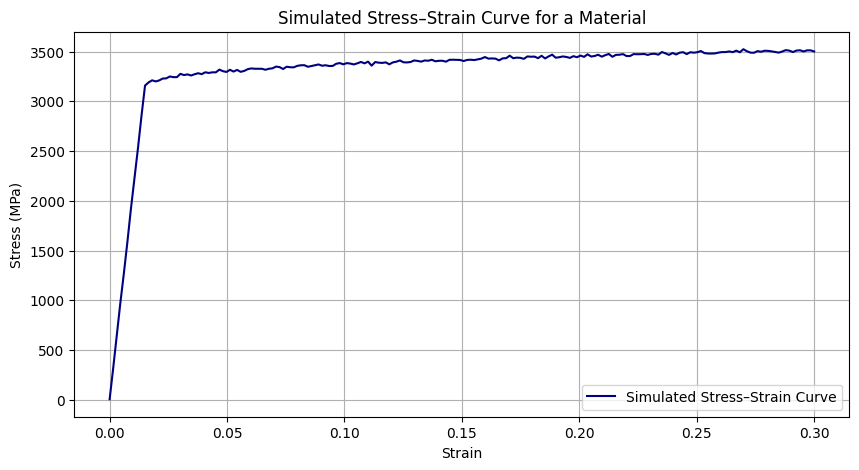

Data Generation: Simulated stress–strain curve with 200 data points generated.


In [3]:
# =============================================================================
# Section 2: Data Generation - Simulating Stress–Strain Curves
# =============================================================================
# In materials science, stress–strain curves provide insight into the mechanical behavior
# of materials. Typically, these curves exhibit an initial linear (elastic) region followed by
# a yield point and a plastic deformation region. In this section, we simulate such a curve
# with a piecewise function. We add noise to mimic the variability seen in experimental data.

def simulate_stress_strain_curve(num_points=200, E=200e3, yield_strain=0.02, k=500, n=0.5, noise_std=5):
    """
    Simulates a stress–strain curve for a material.

    The function uses a piecewise model:
      - For strain < yield_strain, stress = E * strain (elastic region).
      - For strain >= yield_strain, stress = yield_stress + k*(strain - yield_strain)^n (plastic region).
    Gaussian noise is added to simulate experimental variability.

    Args:
        num_points (int): Number of data points along the strain axis.
        E (float): Young's modulus (slope of the elastic region) in MPa.
        yield_strain (float): Strain at yield point.
        k (float): Hardening coefficient in the plastic region.
        n (float): Strain hardening exponent.
        noise_std (float): Standard deviation of Gaussian noise.

    Returns:
        strains (np.array): Array of strain values.
        stresses (np.array): Array of stress values (with noise) in MPa.
    """
    # Generate strain values uniformly from 0 to a maximum strain.
    max_strain = 0.3
    strains = np.linspace(0, max_strain, num_points)

    # Compute stress values based on the strain.
    stresses = np.zeros_like(strains)
    yield_stress = E * yield_strain  # Stress at yield point
    for i, strain in enumerate(strains):
        if strain < yield_strain:
            # Elastic region: linear relationship.
            stresses[i] = E * strain
        else:
            # Plastic region: nonlinear strain hardening.
            stresses[i] = yield_stress + k * ((strain - yield_strain) ** n)

    # Add Gaussian noise to simulate experimental variability.
    noise = np.random.normal(0, noise_std, size=stresses.shape)
    stresses_noisy = stresses + noise

    return strains, stresses_noisy

# Generate a synthetic stress–strain curve using our simulation function.
num_points_curve = 200
strains, stresses = simulate_stress_strain_curve(num_points=num_points_curve,
                                                 E=210e3,           # Example: 210 GPa (converted to MPa: 210e3 MPa)
                                                 yield_strain=0.015,
                                                 k=600,
                                                 n=0.4,
                                                 noise_std=10)

# Plot the simulated stress–strain curve.
plt.figure(figsize=(10, 5))
plt.plot(strains, stresses, label="Simulated Stress–Strain Curve", color="navy")
plt.title("Simulated Stress–Strain Curve for a Material")
plt.xlabel("Strain")
plt.ylabel("Stress (MPa)")
plt.legend()
plt.grid(True)
plt.show()

print("Data Generation: Simulated stress–strain curve with", num_points_curve, "data points generated.")
print("=" * 80)

In [4]:
# =============================================================================
# Section 3: Data Preprocessing - Creating Sequences and Targets
# =============================================================================
# For RNN training, we need to convert our continuous stress–strain curve into sequences.
# Each sequence will consist of a fixed number of consecutive stress measurements,
# and the target is the stress value immediately following the sequence.
# This way, our RNN will learn to predict the next stress value from a given sequence.

def create_time_series_sequences(data, seq_length):
    """
    Converts a 1D time series into overlapping sequences and targets.

    Args:
        data (np.array): 1D array of data points (e.g., stress values).
        seq_length (int): The number of time steps in each input sequence.

    Returns:
        sequences (np.array): Array of input sequences (shape: [num_samples, seq_length]).
        targets (np.array): Array of target values (shape: [num_samples]).
    """
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Define the sequence length (how many past stress values to use).
sequence_length = 20

# Create sequences and targets from the simulated stress data.
sequences, targets = create_time_series_sequences(stresses, sequence_length)
print("Data Preprocessing:")
print("Sequences shape:", sequences.shape)
print("Targets shape:", targets.shape)

# Normalize the sequences and targets to aid model training.
# Here we use standard score normalization (z-score).
mean_stress = np.mean(sequences)
std_stress = np.std(sequences)
sequences_norm = (sequences - mean_stress) / std_stress
targets_norm = (targets - mean_stress) / std_stress

# Convert the numpy arrays to PyTorch tensors.
# Reshape sequences to (num_samples, sequence_length, 1) because each time step has one feature.
sequences_tensor = torch.tensor(sequences_norm, dtype=torch.float32).unsqueeze(-1).to(device)
targets_tensor = torch.tensor(targets_norm, dtype=torch.float32).unsqueeze(-1).to(device)

print("Normalized sequences tensor shape:", sequences_tensor.shape)
print("Normalized targets tensor shape:", targets_tensor.shape)
print("=" * 80)

Data Preprocessing:
Sequences shape: (180, 20)
Targets shape: (180,)
Normalized sequences tensor shape: torch.Size([180, 20, 1])
Normalized targets tensor shape: torch.Size([180, 1])


In [5]:
# =============================================================================
# Section 4: Splitting Data into Training and Testing Sets
# =============================================================================
# We now split our dataset into training and testing sets. A common split ratio is 80/20.
# This ensures that we have sufficient data for training while retaining a portion for evaluating
# the model's performance on unseen data.

split_ratio = 0.8
num_samples_total = sequences_tensor.shape[0]
num_train = int(num_samples_total * split_ratio)
num_test = num_samples_total - num_train

train_X = sequences_tensor[:num_train]
train_y = targets_tensor[:num_train]
test_X = sequences_tensor[num_train:]
test_y = targets_tensor[num_train:]

print("Data Splitting:")
print("Training set shape:", train_X.shape, train_y.shape)
print("Testing set shape:", test_X.shape, test_y.shape)

# Create DataLoaders to iterate through the training and testing sets in batches.
batch_size = 16
train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
test_dataset = torch.utils.data.TensorDataset(test_X, test_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("=" * 80)

Data Splitting:
Training set shape: torch.Size([144, 20, 1]) torch.Size([144, 1])
Testing set shape: torch.Size([36, 20, 1]) torch.Size([36, 1])


In [6]:
# =============================================================================
# Section 5: Defining the Vanilla RNN Model for Regression
# =============================================================================
# We now define a simple Vanilla RNN model in PyTorch.
# The model consists of an RNN layer (with tanh activation) and a fully connected layer that maps
# the final hidden state to the output prediction (the next stress value).
# This model will be trained to perform regression on the stress–strain sequence data.

class StressStrainRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Initializes the Vanilla RNN model for stress–strain prediction.

        Args:
            input_size (int): Number of features per time step (1 in our case).
            hidden_size (int): Number of hidden units in the RNN.
            num_layers (int): Number of RNN layers (stacked RNNs).
            output_size (int): Number of outputs (1 for regression).
        """
        super(StressStrainRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # The RNN layer processes the sequence data.
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # The fully connected layer converts the final hidden state to an output.
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Performs a forward pass through the model.

        Args:
            x (Tensor): Input tensor of shape (batch_size, sequence_length, input_size).

        Returns:
            Tensor: Output predictions of shape (batch_size, output_size).
        """
        # Initialize the hidden state with zeros.
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Pass the input sequence through the RNN layer.
        out, _ = self.rnn(x, h0)
        # Select the output from the last time step.
        out = self.fc(out[:, -1, :])
        return out

# Define model parameters.
input_dim = 1      # Each time step has 1 feature (normalized stress).
hidden_dim = 40    # Number of hidden units (this is a hyperparameter you can tune).
num_layers = 2     # Number of stacked RNN layers.
output_dim = 1     # Single output for regression (next stress value).

# Instantiate the model and print its architecture.
model = StressStrainRNN(input_dim, hidden_dim, num_layers, output_dim).to(device)
print("==== StressStrainRNN Model Architecture ====")
print(model)
print("=" * 80)

==== StressStrainRNN Model Architecture ====
StressStrainRNN(
  (rnn): RNN(1, 40, num_layers=2, batch_first=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
)


==== Training StressStrainRNN Model ====
[StressStrainRNN] Epoch 5/50, Loss: 0.003831
[StressStrainRNN] Epoch 10/50, Loss: 0.003050
[StressStrainRNN] Epoch 15/50, Loss: 0.002355
[StressStrainRNN] Epoch 20/50, Loss: 0.003479
[StressStrainRNN] Epoch 25/50, Loss: 0.002392
[StressStrainRNN] Epoch 30/50, Loss: 0.002643
[StressStrainRNN] Epoch 35/50, Loss: 0.002413
[StressStrainRNN] Epoch 40/50, Loss: 0.002308
[StressStrainRNN] Epoch 45/50, Loss: 0.002546
[StressStrainRNN] Epoch 50/50, Loss: 0.002278
Training completed in 3.53 seconds.


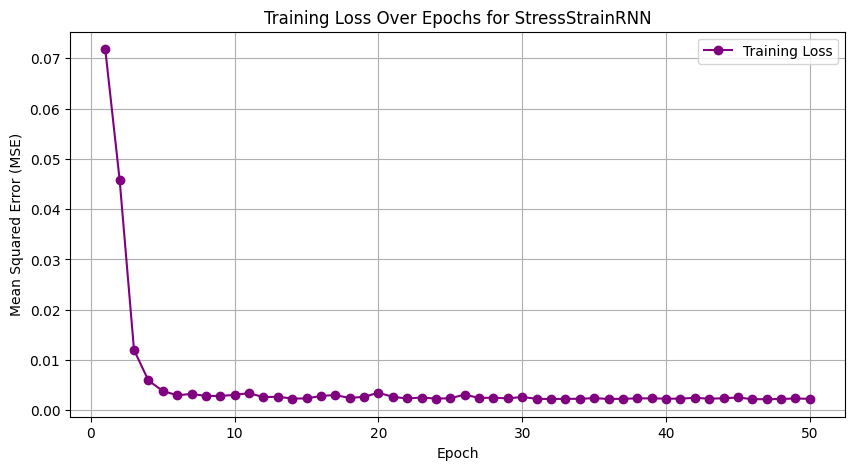

In [7]:
# =============================================================================
# Section 6: Training the RNN Model
# =============================================================================
# In this section, we train the RNN model on our stress–strain dataset.
# We use the Mean Squared Error (MSE) loss function for regression and the Adam optimizer.
# The training loop iterates over the training data, computes the loss, backpropagates the error,
# and updates the model parameters. We record the loss at each epoch to visualize the learning process.

num_epochs = 50
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_history = []

print("==== Training StressStrainRNN Model ====")
start_time = time.time()
for epoch in range(num_epochs):
    model.train()  # Set model to training mode.
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()            # Zero the parameter gradients.
        outputs = model(batch_X)           # Forward pass.
        loss = criterion(outputs, batch_y) # Compute MSE loss.
        loss.backward()                    # Backpropagation.
        optimizer.step()                   # Update model parameters.
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(train_loader)
    train_loss_history.append(avg_loss)
    if (epoch + 1) % 5 == 0:
        print(f"[StressStrainRNN] Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")
print("Training completed in {:.2f} seconds.".format(time.time() - start_time))
print("=" * 80)

# Plot the training loss curve.
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o', color='purple', label='Training Loss')
plt.title("Training Loss Over Epochs for StressStrainRNN")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)
plt.show()

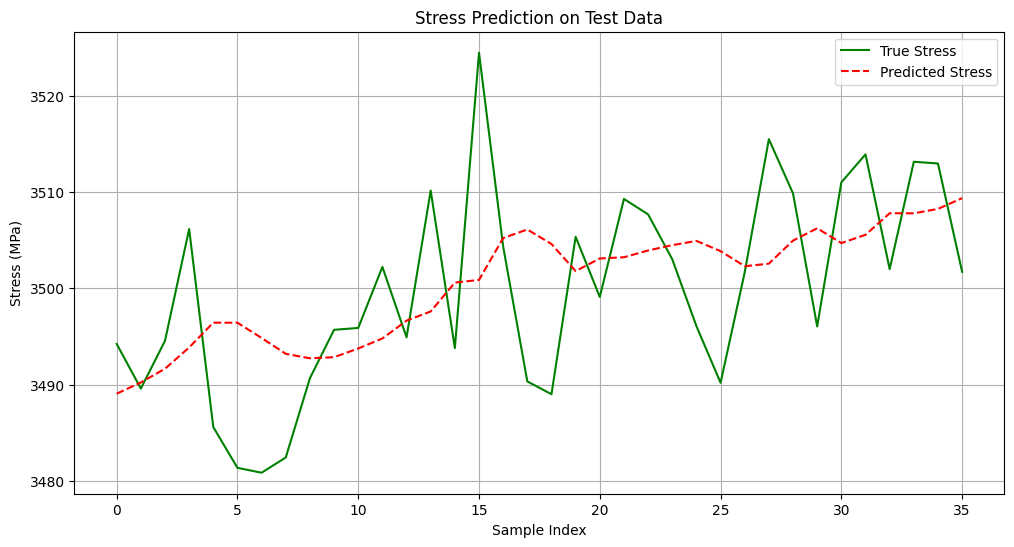

==== Evaluation Metrics ====
Mean Absolute Error (MAE): 7.5346 MPa
Root Mean Squared Error (RMSE): 9.2291 MPa


In [8]:
# =============================================================================
# Section 7: Evaluating the Model on Test Data
# =============================================================================
# Now that the model is trained, we evaluate its performance on the test dataset.
# We compute the predictions on the test sequences and then compare them to the true stress values.
# The normalized predictions are converted back to the original scale for meaningful interpretation.

model.eval()  # Set the model to evaluation mode.
predictions = []
true_vals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        predictions.append(outputs.cpu().numpy())
        true_vals.append(batch_y.cpu().numpy())

# Concatenate predictions and true values from all batches.
predictions = np.concatenate(predictions).flatten()
true_vals = np.concatenate(true_vals).flatten()

# Denormalize the predictions and true values.
predictions_denorm = predictions * std_stress + mean_stress
true_vals_denorm = true_vals * std_stress + mean_stress

# Plot the predicted stress values versus the true stress values.
plt.figure(figsize=(12, 6))
plt.plot(true_vals_denorm, label="True Stress", color="green")
plt.plot(predictions_denorm, label="Predicted Stress", color="red", linestyle="--")
plt.title("Stress Prediction on Test Data")
plt.xlabel("Sample Index")
plt.ylabel("Stress (MPa)")
plt.legend()
plt.grid(True)
plt.show()

# Compute evaluation metrics.
mae = mean_absolute_error(true_vals_denorm, predictions_denorm)
rmse = np.sqrt(mean_squared_error(true_vals_denorm, predictions_denorm))
print("==== Evaluation Metrics ====")
print("Mean Absolute Error (MAE): {:.4f} MPa".format(mae))
print("Root Mean Squared Error (RMSE): {:.4f} MPa".format(rmse))
print("=" * 80)

In [9]:
# =============================================================================
# Section 8: Additional Experiments - Hyperparameter Sensitivity and Sequence Length Variation
# =============================================================================
# In this section, we conduct additional experiments to study how hyperparameters such as the hidden size,
# learning rate, and sequence length affect model performance.
# These experiments are critical in materials science applications, where fine-tuning the model can lead to
# more accurate predictions of material behavior.

def train_model_for_experiment(seq_len, hidden_size_val, lr, epochs=30):
    """
    Trains a StressStrainRNN model for a given sequence length, hidden size, and learning rate.

    Args:
        seq_len (int): Sequence length to use.
        hidden_size_val (int): Hidden size for the RNN.
        lr (float): Learning rate.
        epochs (int): Number of epochs to train.

    Returns:
        float: Final training loss.
    """
    # Create new sequences with the given sequence length.
    seq_data, target_data = create_time_series_sequences(stresses, seq_len)
    mean_temp = np.mean(seq_data)
    std_temp = np.std(seq_data)
    seq_data_norm = (seq_data - mean_temp) / std_temp
    target_data_norm = (target_data - mean_temp) / std_temp
    seq_tensor_local = torch.tensor(seq_data_norm, dtype=torch.float32).unsqueeze(-1).to(device)
    target_tensor_local = torch.tensor(target_data_norm, dtype=torch.float32).unsqueeze(-1).to(device)

    # Split into training and testing using the same ratio.
    num_local = seq_tensor_local.shape[0]
    num_train_local = int(num_local * split_ratio)
    train_X_local = seq_tensor_local[:num_train_local]
    train_y_local = target_tensor_local[:num_train_local]
    local_dataset = torch.utils.data.TensorDataset(train_X_local, train_y_local)
    local_loader = torch.utils.data.DataLoader(local_dataset, batch_size=batch_size, shuffle=True)

    # Initialize the model with specified hidden size.
    model_local = StressStrainRNN(input_dim, hidden_size_val, num_layers, output_dim).to(device)
    optimizer_local = optim.Adam(model_local.parameters(), lr=lr)
    criterion_local = nn.MSELoss()

    loss_history_local = []
    for epoch in range(epochs):
        epoch_loss_local = 0.0
        model_local.train()
        for X_batch, y_batch in local_loader:
            optimizer_local.zero_grad()
            outputs_local = model_local(X_batch)
            loss_local = criterion_local(outputs_local, y_batch)
            loss_local.backward()
            optimizer_local.step()
            epoch_loss_local += loss_local.item()
        avg_loss_local = epoch_loss_local / len(local_loader)
        loss_history_local.append(avg_loss_local)
    return loss_history_local[-1]

# Define hyperparameter ranges for experiments.
seq_lengths = [15, 20, 25]
hidden_sizes = [30, 40, 50]
learning_rates = [0.0005, 0.001, 0.005]

experiment_results = {}
print("==== Hyperparameter Sensitivity Analysis ====")
for s_len in seq_lengths:
    for h_size in hidden_sizes:
        for lr_val in learning_rates:
            final_loss = train_model_for_experiment(s_len, h_size, lr_val, epochs=30)
            experiment_results[(s_len, h_size, lr_val)] = final_loss
            print(f"Seq Len: {s_len}, Hidden Size: {h_size}, LR: {lr_val} -> Final Loss: {final_loss:.6f}")

print("\nHyperparameter Experiment Results:")
for params, loss_val in experiment_results.items():
    s_len, h_size, lr_val = params
    print(f"Sequence Length: {s_len}, Hidden Size: {h_size}, Learning Rate: {lr_val} => Final Loss: {loss_val:.6f}")
print("=" * 80)

==== Hyperparameter Sensitivity Analysis ====
Seq Len: 15, Hidden Size: 30, LR: 0.0005 -> Final Loss: 0.001723
Seq Len: 15, Hidden Size: 30, LR: 0.001 -> Final Loss: 0.002474
Seq Len: 15, Hidden Size: 30, LR: 0.005 -> Final Loss: 0.002806
Seq Len: 15, Hidden Size: 40, LR: 0.0005 -> Final Loss: 0.001805
Seq Len: 15, Hidden Size: 40, LR: 0.001 -> Final Loss: 0.001865
Seq Len: 15, Hidden Size: 40, LR: 0.005 -> Final Loss: 0.002272
Seq Len: 15, Hidden Size: 50, LR: 0.0005 -> Final Loss: 0.002155
Seq Len: 15, Hidden Size: 50, LR: 0.001 -> Final Loss: 0.002171
Seq Len: 15, Hidden Size: 50, LR: 0.005 -> Final Loss: 0.002151
Seq Len: 20, Hidden Size: 30, LR: 0.0005 -> Final Loss: 0.002494
Seq Len: 20, Hidden Size: 30, LR: 0.001 -> Final Loss: 0.002225
Seq Len: 20, Hidden Size: 30, LR: 0.005 -> Final Loss: 0.002614
Seq Len: 20, Hidden Size: 40, LR: 0.0005 -> Final Loss: 0.002105
Seq Len: 20, Hidden Size: 40, LR: 0.001 -> Final Loss: 0.002522
Seq Len: 20, Hidden Size: 40, LR: 0.005 -> Final Loss

In [10]:
# =============================================================================
# Section 9: Saving and Loading the Trained Model and Final Summary
# =============================================================================
# Once we have trained our model, it is useful to save it so that we do not have to retrain
# every time we want to make predictions. The following section demonstrates how to save the
# trained model to disk and then load it later for further use or evaluation.

model_save_path = "stress_strain_rnn_model.pth"
torch.save(model.state_dict(), model_save_path)
print("Model saved to", model_save_path)

# Demonstrate model loading.
loaded_model = StressStrainRNN(input_dim, hidden_dim, num_layers, output_dim).to(device)
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.eval()
print("Model loaded from", model_save_path)
print("=" * 80)

Model saved to stress_strain_rnn_model.pth
Model loaded from stress_strain_rnn_model.pth


<ipython-input-10-7488890f7ebb>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_save_path))


In [11]:

# =============================================================================
# Section 10: Final Summary and Future Directions
# =============================================================================
# In this script, we have:
#   - Simulated a synthetic stress–strain curve using a piecewise model that mimics elastic
#     and plastic deformation in materials, with added noise to simulate experimental data.
#   - Preprocessed the data by converting the continuous stress series into overlapping sequences,
#     which serve as input to our RNN model.
#   - Split the dataset into training and testing sets, and created DataLoaders for batch processing.
#   - Defined a Vanilla RNN model in PyTorch to perform regression and predict the next stress value.
#   - Trained the model while logging the loss over epochs and visualized the training loss.
#   - Evaluated the model’s predictions against the true values on the test set, and computed
#     evaluation metrics such as MAE and RMSE.
#   - Conducted additional experiments varying the sequence length, hidden size, and learning rate,
#     and performed a hyperparameter sensitivity analysis to understand their impact on model performance.
#   - Saved the trained model for future use.
#
# Key observations:
#   - Data preprocessing (normalization, sequence generation) is critical for training success.
#   - The RNN was able to learn the underlying pattern of the stress–strain curve despite the added noise.
#   - Hyperparameter tuning significantly impacts performance, and experiments can guide you to select
#     optimal values for your specific application.
#
# Future directions may include:
#   - Experimenting with advanced RNN variants such as LSTM or GRU, which could capture long-term dependencies better.
#   - Using real experimental stress–strain data from materials science.
#   - Extending the model to multi-step forecasting or classification of material properties.
#
# Thank you for exploring this script on stress–strain prediction using a Vanilla RNN. We hope that this
# comprehensive tutorial provides a solid foundation for applying deep learning techniques to materials science
# problems and inspires further experimentation and research in the field.

print("==== Final Summary ====")
print("Stress–Strain RNN prediction completed successfully.")
print("Key evaluation metrics (on test data):")
print("  MAE: {:.4f} MPa".format(mae))
print("  RMSE: {:.4f} MPa".format(rmse))
print("Experimentation on hyperparameters provided additional insights into model tuning.")
print("Future work may involve advanced architectures and real-world data applications.")
print("Thank you for exploring this materials science RNN tutorial!")
print("=" * 80)

# End of Script


==== Final Summary ====
Stress–Strain RNN prediction completed successfully.
Key evaluation metrics (on test data):
  MAE: 7.5346 MPa
  RMSE: 9.2291 MPa
Experimentation on hyperparameters provided additional insights into model tuning.
Future work may involve advanced architectures and real-world data applications.
Thank you for exploring this materials science RNN tutorial!
